In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt  
import math
import os

# 添加明暗分界线检查条件

In [10]:
# 自动识别出最接近量表的图片并分割
def cutPicOld(path):
    # 0 读入原始照片
    img = cv2.imread(path,0)
    # plt.imshow(img,cmap = 'gray')
    # plt.show()
    
    # 1 水表图形分割
    aim = img[:1000, 700:1000]
    
    print("分割后图片为：")
    plt.imshow(aim,cmap = 'gray')
    plt.show()
    
    return aim

In [11]:
# ========== 鼠标交互切割矩形 ==========
global img
global point1, point2

def on_mouse(event, x, y, flags, param):
    
    # 读入图片
    global img, point1, point2
    img2 = img.copy()
    
    if event == cv2.EVENT_LBUTTONDOWN:
        #左键点击
        point1 = (x,y)
        cv2.circle(img2, point1, 10, (0,255,0), 5)
        cv2.imshow('image', img2)
    elif event == cv2.EVENT_MOUSEMOVE and (flags & cv2.EVENT_FLAG_LBUTTON): 
        #按住左键拖曳
        cv2.rectangle(img2, point1, (x,y), (255,0,0), 5)
        cv2.imshow('image', img2)
    elif event == cv2.EVENT_LBUTTONUP:  
        #左键释放
        point2 = (x,y)
        cv2.rectangle(img2, point1, point2, (0,0,255), 5) 
        cv2.imshow('image', img2)
        min_x = min(point1[0], point2[0])     
        min_y = min(point1[1], point2[1])
        width = abs(point1[0] - point2[0])
        height = abs(point1[1] -point2[1])
        cut_img = img[min_y:min_y+height, min_x:min_x+width]
        # cv2.imwrite('lena3.jpg', cut_img)

def cutPicByMouse(path):
    global img, point1, point2
    img = cv2.imread(path)
    img_gray = cv2.imread(path,0)
    
    getAim = True
    res = img_gray.copy()
    
    while getAim:
        print("请用鼠标框选待识别区域，框选结束后点击任意键推出绘图模型")
        cv2.namedWindow('image', 0)
        cv2.setMouseCallback('image', on_mouse)
        cv2.imshow('image', img)
        cv2.waitKey(0)
        cv2.destroyAllWindows() 
        
        print("查看框选范围，点击任意键推出：")
        
        min_x = min(point1[0], point2[0])     
        min_y = min(point1[1], point2[1])
        width = abs(point1[0] - point2[0])
        height = abs(point1[1] -point2[1])
        aim = img[min_y:min_y+height, min_x:min_x+width]
        
        cv2.imshow('Cut Pic', aim)
        cv2.waitKey(0)
        cv2.destroyAllWindows() 
        
        conti = input("如果框选失败，请输入 0 重新框选，输入其他内容结束框选:")
        if conti != '0':
            getAim = False
            res = img_gray[:1000, min_x:min_x+width]
            
        # print(conti)
        # print(type(conti))
        
    # return res
    return min_x, min_x+width, min_y, min_y+height

In [12]:
def preProcess(aim, contType = "sim", Bi_LB = 177, hist_method = "eh"):
    # 2. 预处理
    # 2.1 直方图均衡化提高度对比度

    # 查看原始直方图
    # plt.hist(aim.ravel(),256,[0,256]);  
    # plt.show() 

    # 先平滑后均衡
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(aim,-1,kernel)
    # dst = cv2.GaussianBlur(dst,(5,5),0)
    
    # 直方图均衡化
    equ = cv2.equalizeHist(dst)
    # 限制自适应均衡化
    if hist_method == "clahe":
        clahe = cv2.createCLAHE(5,(8,8))
        equ = clahe.apply(dst)
    # 直方图归一化
    # equ = cv2.normalize(dst, None, 0, 255, cv2.NORM_MINMAX)
    
    # print(equ)
    
    '''
    print("平滑后图片为：")
    plt.subplot(121),plt.imshow(aim,cmap = 'gray'),plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(equ,cmap = 'gray'),plt.title('Averaging')
    plt.xticks([]), plt.yticks([])
    plt.show()
    '''

    # 查看平滑后直方图
    # plt.hist(equ.ravel(),256,[0,256]);  
    # plt.show() 
    
    # 2.2 闭运算：先膨胀后腐蚀, 填充前景物体中的小洞
    closing = cv2.morphologyEx(equ, cv2.MORPH_CLOSE, kernel)

    # 2.3 图像去噪
    dst_de = cv2.fastNlMeansDenoising(closing, None, 50, 7, 21)
    '''
    print("去除噪点后图片为：")
    plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
    plt.subplot(122),plt.imshow(dst_de, cmap = 'gray')  
    plt.title('Denoise Image'), plt.xticks([]), plt.yticks([])  
    plt.show() 
    '''
    
    # 2.4 二值化
    ret,thresh = cv2.threshold(dst_de,Bi_LB,255,0)
    '''
    print("二值化后图片为：")
    plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
    plt.subplot(122),plt.imshow(thresh, cmap = 'gray')  
    plt.title('Thresh Image'), plt.xticks([]), plt.yticks([])  
    plt.show() 
    '''
    
    # 2.5 Canny 边缘检测
    edges = cv2.Canny(thresh,50,150) 
    '''
    print("边缘检测结果为：")
    plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
    plt.subplot(122),plt.imshow(edges, cmap = 'gray')  
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])  
    plt.show()  
    '''
    
    # 2.6 轮廓提取
    ret,thresh = cv2.threshold(dst_de,Bi_LB,255,0)
    
    if contType == "sim":
        contour, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    else:
        contour, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        
    '''
    print("水表轮廓为：")
    plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])  

    color = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
    result = cv2.drawContours(color, contour, -1, (0,255,0), 2) #轮廓用绿色绘制

    plt.subplot(122),plt.imshow(result)  
    plt.title('Contours Image'), plt.xticks([]), plt.yticks([])  
    plt.show()  
    '''
    return equ, contour

In [13]:
# 基于轮廓形状找出对称连续线段
def findContourByShape(leftContour, rightContour):
    # ============== 找出左右连续线段 ======================
    leftPos = 0
    leftSize = len(leftContour)
    
    rightPos = 0
    rightSize = len(rightContour)
    
    # 1 扫描左侧轮廓中的连续线段
    leftBlock = []
    for w in range(0, 200):
        # 1.1 基于点的高度进行分块
        w2 = w * 5
        block = []
        while (leftPos < leftSize and leftContour[leftPos][0, 1] < w2 + 5):
            if leftContour[leftPos][0, 1] >= w2:
                block.append(leftContour[leftPos])
            leftPos += 1
            
        # 1.2 检查同一高度block中是否存在连续线段
        conNum = 0
        maxConLen = 0
        pre = 0
        block.sort(key=takeFirst)
        for arr in block:
            if (arr[0, 0] - pre) < 5:
                conNum += 1
                maxConLen = max(maxConLen, conNum)
            else:
                conNum = 0
            pre = arr[0, 0]
            
        # 1.3 保存连续线段
        if maxConLen > 15:
        # if len(block) > 4:
            leftBlock.append(block)
        if (leftPos >= leftSize):
            break
    
    # 2 扫描右侧轮廓中的连续线段
    rightBlock = []
    for w in range(0, 200):
        # 2.1 基于点的高度进行分块
        w2 = w * 5
        block = []
        while (rightPos < rightSize and rightContour[rightPos][0, 1] < w2 + 5):
            if rightContour[rightPos][0, 1] >= w2:
                block.append(rightContour[rightPos])
            rightPos += 1
            
        # 2.2 检查同一高度block中是否存在连续线段
        conNum = 0
        maxConLen = 0
        pre = 0
        block.sort(key=takeFirst)
        for arr in block:
            if (arr[0, 0] - pre) < 5: 
                conNum += 1
                maxConLen = max(maxConLen, conNum)
            else:
                conNum = 0
            pre = arr[0, 0]
            
        # 2.3 保存连续线段    
        if maxConLen > 15:
            rightBlock.append(block)
        if (rightPos >= rightSize):
            break
     
    # 返回图块中对称的连续线段数
    print(len(leftBlock), len(rightBlock))
    symNum = min(len(leftBlock), len(rightBlock))
    
    return symNum

# 排序设定函数
def takeFirst(elem):
    return elem[0, 0]

def takeSecond(elem):
    return elem[0, 1]

# 自动识别出最接近量表的图片并分割
def cutPic(path, fileName):
    # 0 读入原始照片
    img = cv2.imread(path,0)
    
    # 0.2 照片尺寸
    high = len(img)
    wid = img[0].size
    
    # 0,3 输出左右边界
    leftCol = 500
    rightCol = 1100
    
    plt.imshow(img[:, leftCol:rightCol])  
    plt.title('Limit Image'), plt.xticks([]), plt.yticks([])  
    plt.show()
    
    # 1 水表图形分割
    windowSize = 100
    print("预设的滑动窗口尺寸为：", windowSize)
    
    windowNum = int((rightCol - 300 - leftCol) / windowSize)
    print("图片共分割为",windowNum,"个待扫描图块")
    
    maxSym = 0
    maxWindow = 0
    print("开始对图片进行自动滑动窗口扫描：")
    
    # print("待扫描图块范围为：")
    print("正在扫描图块：")
    
    for i in range(0, windowNum):
        bias = i * windowSize + leftCol
        
        if (bias + 300 >= rightCol):
            break
        
        aim = img[0:1000, bias:bias+300]
        # print("[0:1000, ",bias,":",bias+300,"]", end=', ')
        print(i + 1, end=', ')
        
        # 1 提取轮廓
        equ, contour = preProcess(aim, "none")
        
        # ================= 2 计算当前图例中最大轮廓面积 =======================
        maxA = 0
        maxIn = 0
        for j in range(0, len(contour)):
            arr = contour[j]
            area = cv2.contourArea(arr)
            if area > maxA:
                maxA = area
                maxIn = j
                
        # print("当前图块的最大轮廓面积为：", maxA)
        # if maxA < 150000:
            # print("轮廓面积过小，跳过当前窗口。")
            # continue
        
         # ================= 3 划分左右轮廓 =================
        midWid = wid / 2
        
        leftContour = []
        rightContour = []
        
        # 开始划分
        for arr in contour[maxIn]:
            if arr[0, 0] <= 150:
                leftContour.append(arr)
            else:
                rightContour.append(arr)
        
        # ================= 4 按照高度排序 =================
        leftContour.sort(key=takeSecond)
        rightContour.sort(key=takeSecond)
        
        leftPos = 0
        leftSize = len(leftContour)
    
        rightPos = 0
        rightSize = len(rightContour)
        
        # ================= 5 计算对称点数量 =================
        symNum = 0
        
        # 方法1：基于形状进行计算
        # 用时最少，准确率一般
        # symNum = findContourByShape(leftContour, rightContour)
        
        # 方法2：穷举法
        # 用时最多，准确率最高
        for a1 in range(0, leftSize):
            for a2 in range(0, rightSize):
                 if abs(leftContour[a1][0, 1] - rightContour[a2][0, 1]) < 3:
                        if abs(abs(leftContour[a1][0, 0] - 150) - abs(rightContour[a2][0, 0] - 150)) < 30:
                            symNum += 1
    
        # 方法3：顺序法
        # 用时中等，准确率较好
        ''' 
        leftPos = 0
        rightPos = 0
        while leftPos < leftSize and rightPos < rightSize :
            if abs(leftContour[leftPos][0, 1] - rightContour[rightPos][0, 1]) < 10:
                if abs(leftContour[leftPos][0, 0] - 150) < 20 and abs(rightContour[rightPos][0, 0] - 150) < 20:
                    print(leftContour[leftPos], ":", rightContour[rightPos])
                    symNum += 1   
            if (leftContour[leftPos][0, 1] < rightContour[rightPos][0, 1]):
                leftPos += 1
            else:
                rightPos += 1
        '''
        # print("该图块对称点个数为：", symNum)

        if symNum > maxSym:
            maxSym = symNum
            maxWindow = i
            # print(maxSym, symNum, i)

    print("")
    
    bias = maxWindow * windowSize + leftCol
    aim = img[:1000, bias:bias+300]
    equ, contour = preProcess(aim)
    
    plt.subplot(121),plt.imshow(aim, cmap = 'gray')  
    plt.title('Cut Image'), plt.xticks([]), plt.yticks([])
    
    color = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
    result = cv2.drawContours(color, contour, -1, (0,255,0), 2) #轮廓用绿色绘制

    plt.subplot(122),plt.imshow(result)  
    plt.title('Contours Image'), plt.xticks([]), plt.yticks([]) 
    
    savePath = fileName + "_水表分割结果.jpg"
    plt.savefig(savePath)
    
    print("自动识别得到的与水表最近似的图块已保存在：", savePath)
    # print("自动识别得到的与水表最近似的图块为：")
    
    # plt.show()  
    return aim

In [15]:
# ============== 提取轮廓组中最大面积轮廓 ==============
def maxContourArea(contour):
    maxArea = 0
    maxA = 0
    for j in range(0, len(contour)):
        arr = contour[j]
        area = cv2.contourArea(arr)
        if area > maxArea:
            maxArea = area
            maxA = j
    return maxA

# ============== 提取轮廓组中最大点数轮廓 ==============
def maxContourSize(contour):
    maxA = 0
    maxS = contour[0].size
    for i in range(0, len(contour)):
        if (contour[i].size > maxS):
            maxA = i 
    return maxA

# ============== 找出最低水位线位置 ==============
def minWaterLine(maxContour, Height_0):
    rub = 0
    minH = 0
    minIn = 0
    
    lb = maxContour[0][0, 0]  # 左边界
    rb = 0  # 右边界
    
    for i in range(0, len(maxContour)):
        if maxContour[i][0, 1] <= Height_0:
            rub = i
            if  maxContour[i][0, 1] > minH:
                minH = maxContour[i][0, 1]
                minIn = i
        wid = maxContour[i][0, 0]
        lb = min(lb, wid)
        rb = max(rb, wid)
        
    return minIn, rb - lb
    
# ============== 找出最高水位线位置 ==============
def maxWaterLine(maxContour, Height_0, minH):
    rub = 0
    maxH = Height_0
    minIn = 0
    
    lb = maxContour[0][0, 0]  # 左边界
    rb = 0  # 右边界
    
    for i in range(0, len(maxContour)):
        if maxContour[i][0, 1] < Height_0 and maxContour[i][0, 1] > minH and maxContour[i][0, 0] > 10 and maxContour[i][0, 0] < 50:
            rub = i
            if  maxContour[i][0, 1] < maxH:
                maxH = maxContour[i][0, 1]
                minIn = i
                
        wid = maxContour[i][0, 0]
        lb = min(lb, wid)
        rb = max(rb, wid)
        
    return minIn, rb - lb

# ============== 基于统计指标找出水位线位置 ==============

# 将对象加入上下[-2:2]中
def addHeight(pdict, temh):
    if temh > 2 :
        if pdict.get(temh - 2, -1) >= 0:
            pdict[temh - 2] = pdict[temh - 2] + 1
        else:
            pdict[temh - 2] = 1
            
    if temh > 1 :
        if pdict.get(temh - 1, -1) >= 0:
            pdict[temh - 1] = pdict[temh -1] + 1
        else:
            pdict[temh - 1] = 1
            
    if pdict.get(temh, -1) >= 0:
        pdict[temh] = pdict[temh] + 1
    else:
        pdict[temh] = 1
        
    if pdict.get(temh + 1, -1) >= 0:
        pdict[temh + 1] = pdict[temh + 1] + 1
    else:
        pdict[temh + 1] = 1    
    
    if pdict.get(temh + 2, -1) >= 0:
        pdict[temh + 2] = pdict[temh + 2] + 1
    else:
        pdict[temh + 2] = 1  
         
    return pdict

# 基于众数找出平均水位
def averWaterLine_mode(maxContour, Height_0, minH):
    lb = maxContour[0][0, 0]  # 左边界
    rb = 0  # 右边界
    
    pdict = {}  # Dict 来记录各个高度点数
    
    for i in range(0, len(maxContour)):
        temh = maxContour[i][0, 1]
        
        wid = maxContour[i][0, 0]
        
        if temh > Height_0 - 2 or temh < minH + 2:
            continue
        
        if  wid < 5 or  wid > 55:
            continue
        
        lb = min(lb, wid)
        rb = max(rb, wid)
        
        addHeight(pdict, temh)
         
    # print(pdict)
    maxH = 0
    maxF = 0
    for key,values in pdict.items():
        if key == 0:
            continue
        if values > maxF:
            maxH = key
            maxF = values
            
    freDict = {}
    for i in range(0, 60):
        freDict[i] = 0
        
    temF = 0
    for i in range(0, len(maxContour)):
        temh = maxContour[i][0, 1]
        wid = maxContour[i][0, 0]
        if temh > Height_0 - 2 or temh < minH + 2:
            continue
        if  wid < 5 or  wid > 55:
            continue
            
        if (temh >= maxH and temh - maxH <= 10) or temh <= maxH:
            if (freDict[wid] == 0):
                freDict[wid] = 1
                temF += 1
        
    return maxH, temF


# 计算当前高度轮廓点数
def colWid_Mode(maxContour, maxH, Height_0, minH):
    
    freDict = {}
    for i in range(0, 60):
        freDict[i] = 0
        
    temF = 0
    # print("maxH = ", maxH)
    
    for i in range(0, len(maxContour)):
        temh = maxContour[i][0, 1]
        wid = maxContour[i][0, 0]
        
        if temh > Height_0 - 2 or temh < minH + 2:
            continue
        if  wid < 2 or  wid > 58:
            continue
            
        if temh <= maxH:
            if (freDict[wid] == 0):
                freDict[wid] = 1
                temF += 1
                # print(wid, ":", temh)
        
    return temF

# 基于均值找出平均水位
def averWaterLine(maxContour, Height_0, minH):
    lb = maxContour[0][0, 0]  # 左边界
    rb = 0  # 右边界
    pdict = []
    for i in range(0, len(maxContour)):
        temh = maxContour[i][0, 1]
        
        if temh > Height_0 - 2 or temh < minH + 2:
            continue
        
        wid = maxContour[i][0, 0]
        lb = min(lb, wid)
        rb = max(rb, wid)
        
        if wid >55 or wid < 5:
            continue
        
        pdict.append(temh)
        
    return int(np.mean(pdict)), rb - lb


# 基于均值找出目标附近平均水位
def averWaterLine(maxContour, Height_0, minH, aimIn):
    aimH = maxContour[aimIn][0, 1]
    
    sortContour = []
    for con in maxContour:
        sortContour.append(con)
        
    sortContour.sort(key=takeSecond)
    maxContour = sortContour
    
    mid = 0
    for i in range(0, len(maxContour)):
        if maxContour[i][0, 1] == aimH:
            mid = i
            break
            
    pdict = []
    pre = aimH
    l = mid - 1
    while l >= 0 :
    # for l in range(mid - 1: -1 : 0):
        if maxContour[l][0, 0] > 10 and maxContour[l][0, 0] < 50: 
            if abs(maxContour[l][0, 1] - pre) < 2 : 
                pdict.append(maxContour[l][0, 1])
                pre = maxContour[l][0, 1]
            else:
                break
        l -= 1
            
    pre = aimH
    for r in range(mid, len(maxContour)):
        if maxContour[r][0, 0] > 10 and maxContour[r][0, 0] < 50:
            if abs(maxContour[r][0, 1] - pre) < 2:
                pdict.append(maxContour[r][0, 1])
                pre = maxContour[r][0, 1]
            else:
                break
    
    # print(pdict, mid)
    
    # 轮廓不满足要求
    if len(pdict) < 30:
        return -1
    
    return int(np.mean(pdict))

# ============== 计算指定高度平均像素值 ==============
def countAverPixel(equ, leftBound, rightBound, height):
    num = 0
    P_total = 0
    
    for i in range(leftBound, rightBound):
        P_total += equ[height, i]
        num += 1
    
    return P_total / num

# ============== 水平计算分布标准差 ==============
def calSSD(aim, leftLvBound, rightLvBound, Height_0):
    z_arr = []
    for p in range(leftLvBound, rightLvBound):
        z_arr.append(aim[Height_0 + 1][p])
        
    Pixel_UB_threshold = np.std(z_arr, ddof=1)
    return Pixel_UB_threshold

# 垂直计算分布标准差
def calColSSD(aim, LB, RB, top, down):
    z_arr = []
    for p in range(top, down):
        z_arr.append(countAverPixel(aim, LB, RB, p))
        
    Pixel_UB_threshold = np.std(z_arr, ddof=1)
    return Pixel_UB_threshold

# ============== 检查上下高度是否同分布 ==============
def checkSSD(aim, LB, RB, top, down, zSSD):
    # mark
    isRealLine = True

    # ========== 计算从当前水位线 minHpre 到零刻度的标准差 ==========
    tem_ssd = calColSSD(aim, LB, RB, top, down) # / math.sqrt(down - top)
    # print("tem_ssd = ", tem_ssd, ":", zSSD)
    if (tem_ssd > zSSD * 2):
        isRealLine = False
    
    # ========== 检查当前像素分布 ==========
    '''
    zeroPixel = countAverPixel(aim, LB, RB, down - 1)
    
    for th in range(top, down):
        # 暂定像素
        temP = countAverPixel(aim, LB, RB, th)

        # 计算是否超过误差上限
        print(temP, "->", meanV, ":", th, ",", tem_ssd)
        if  abs(temP - meanV) > tem_ssd * 2:
            isRealLine = False
            print("当前像素差值超过标准差 * 2，结束迭代")
            break
    '''        
    return isRealLine
    
# ============== 计算水位线 ==============

def getWaterLine(equ, contour, aim, fileName, filePath, uh, lh):
    # print("开始识别水位线", end=', ')
    # ============================ 3.1 找出量表轮廓位置: max s.t. contour[0].size ==============
    
    # 方法 1： 基于轮廓点数找出量表轮廓 ==============
    # maxA = maxContourSize(contour) 
    
    # 方法 2： 基于轮廓面积找出量表轮廓 ==============
    maxA = maxContourArea(contour)
     
    '''
    print("水表轮廓为：")
    plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])  

    color = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
    result = cv2.drawContours(color, [contour[maxA]], -1, (0,255,0), 2) #轮廓用绿色绘制

    plt.subplot(122),plt.imshow(result)  
    plt.title('Contours Image'), plt.xticks([]), plt.yticks([])  
    plt.show()  
    '''
    
    # ============================ 3.2 分割出量表区域 [st : en] ============================
    st = 0
    while (contour[maxA][st][0, 1] < len(equ) / 3 * 2):
        st += 1;
    
    en = st + 1
    while (contour[maxA][en][0, 1] > len(equ) / 3 * 2):
        en += 1; 
    
    # print("量表区域", st, en, end=', ')   # 量表区域：[st : en]
    
    # ============================ 3.3 找出最低端零刻度 ============================
    Index_0 = 0
    Height_0 = 0  # 零刻度高度
    
    for i in range(st, en):
        if (contour[maxA][i][0, 1] > Height_0 and contour[maxA][i][0, 1] <= lh):
            Index_0 = i
            Height_0 = contour[maxA][i][0, 1]

    # print("零刻度位置", contour[maxA][Index_0], end=', ') # 零刻度位置

    # ============================ 3.4 记录零刻度边界 ============================
    arr_zero = []

    left_0 = contour[maxA][Index_0][0, 0]
    right_0 = left_0
    
    # ========== 找出零刻度左右边界 ==========
    for i in range(st, en):
        if (abs(contour[maxA][i][0, 1] - Height_0) < 20):
            arr_zero.append(contour[maxA][i])
            if (contour[maxA][i][0, 0] < left_0):
                left_0 = contour[maxA][i][0, 0]
            if (contour[maxA][i][0, 0] > right_0):
                right_0 = contour[maxA][i][0, 0]    
        
    # print("零刻度位置为:[",Height_0,",", left_0,":",right_0,"]") # 零刻度坐标
     
    # ========== 绘制零刻度图像 ==========
    zero_color = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
    zero_color[Height_0 - 2 : Height_0 + 2, left_0:right_0] = (0,255,0)
    
    plt.imshow(zero_color[300:, :])  
    plt.title(' Zero Pos'), plt.xticks([]), plt.yticks([])  
    
    savePath = filePath + "/log/" + fileName + "_零刻度.jpg"
    plt.savefig(savePath)
    
    print("1.零刻度位置已保存在：", savePath)
    # plt.show() 
    
    # ============================ 3.5 记录刻度位置数组 ============================
    
    # ========== 基于零刻度位置提取水表图块 ==========
    
    zero2scale = 20 # 左右边界倾斜缓冲
    
    # ========== 手动设置坐标边界 ==========
    right_bound = min(right_0 + zero2scale, 300) # 刻度右边界
    left_bound = max(left_0 - zero2scale, 0)   # 刻度左边界
    
    mid_bound = int((right_bound + left_bound) / 2) # 刻度中线
    
    # print("刻度边界为: [",left_bound, ",", right_bound, "]", end=', ')
    
    # ========== 找到水表轮廓 ==========
    
    waterTable = aim[:1000, left_bound:right_bound]
    
    equW, contourW = preProcess(waterTable)
    
    maxAW = maxContourArea(contourW)
            
    # print("提取得到的刻度轮廓为：")
    # print(contourW[maxAW])
    
    wt_color = cv2.cvtColor(equW, cv2.COLOR_GRAY2BGR)
    wt_result = cv2.drawContours(wt_color, [contourW[maxAW]], -1, (0,255,0), 2) #轮廓用绿色绘制
    
    plt.imshow(wt_result)  
    plt.title(' Water Table'), plt.xticks([]), plt.yticks([])  
    
    savePath = filePath + "/log/" + fileName + "_刻度轮廓.jpg"
    plt.savefig(savePath)
    print("2.刻度轮廓已保存在：", savePath)
    # plt.show()
    
    # ============================ 3.6 计算单位刻度长度 ============================
    # ========== 找到垂直方向的分界线 ==========
    divLine = left_0
    while int(aim[Height_0 - 5][divLine + 1]) - int(aim[Height_0 - 5][divLine]) < 80:
        # 分界线满足左暗右明
        if (aim[Height_0 - 5][divLine] < 80 and aim[Height_0 - 5][divLine + 1] > 80):
            break
        divLine += 1
        
    '''
    # print(divLine, equ[Height_0 - 5][divLine], equ[Height_0 - 5][divLine + 1])
    # 绘制查看分界线效果
    zero_color2 = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
    zero_color2[: , divLine - 2 : divLine + 2] = (0,255,0)
    
    plt.imshow(zero_color2)  
    plt.title(' Divide Line'), plt.xticks([]), plt.yticks([])  
    plt.show()
    '''
    
    # ========== 找到水平方向分界线 ==========
    divRow = Height_0 - 2
    # print("divRow = ", divRow, divLine)
    
    zeroPixel = int(aim[divRow][divLine - 2]) # 零刻度像素值
    # print("zeroPixel = ", zeroPixel, aim[divRow][divLine + 2], end=', ')
    
    while abs(int(aim[divRow - 1][divLine]) - zeroPixel) < 50:
        # 分界线满足下暗上明
        # print(aim[divRow - 1][divLine])
        if abs(int(aim[divRow - 1][divLine]) - int(aim[divRow][divLine])) > 50:
            break
        divRow -= 1
     
    '''
    # print(divRow, equ[divRow - 1][divLine], equ[divRow][divLine])
    # 绘制查看分界线效果
    zero_color2 = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
    zero_color2[divRow - 2 : divRow + 2, :] = (0,255,0)
    
    plt.imshow(zero_color2)  
    plt.title(' Divide Line'), plt.xticks([]), plt.yticks([])  
    plt.show()
    '''
    
    # lengthPer = div / num # 单位刻度
    # lengthPer = 20.5
    
    # lengthPer = Height_0 - divRow 
    lengthPer = 11
    print("单位刻度的图中平均长度为：", lengthPer)
    
    '''
    # 可视化检查单位刻度
    zero_color2 = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
    zero_color2[Height_0 - 1 : Height_0 + 1, left_0:right_0] = (0,255,0)
    zero_color2[Height_0 - int(22) - 1 : Height_0 - int(22) + 1, left_0:right_0] = (0,255,0)
    
    plt.imshow(zero_color2[500:, :])  
    plt.title(' Zero Pos'), plt.xticks([]), plt.yticks([])  
    plt.show()
    '''
    
    # ============================ 3.7 获得轮廓转折点 ============================
    
    # ============== 左水位线范围 ==============
    leftLvBound = max(left_0 - 65, 0)
    rightLvBound = min(left_0 - 5, 300)
    
     # ============== 3.7.1 基于刻度边界划分水位线区域 ==============
    leftLine = aim[:1000, leftLvBound : rightLvBound]
    
    '''
    # 绘制左水位线轮廓
    plt.imshow(leftLine, cmap = 'gray')  
    plt.title('leftLine'), plt.xticks([]), plt.yticks([])  
    plt.show() 
    '''
    
    # ============== 3.7.2 测试初步水位线 ==============
    equ_left, contour_left = preProcess(leftLine, 'none') # 水位线轮廓
    
    # 提取左水位线
    maxAL = maxContourArea(contour_left)  # 最大轮廓位置
    
    '''
    print("左水位线轮廓为：")
    plt.subplot(121),plt.imshow(leftLine, cmap = 'gray')  
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])  

    color = cv2.cvtColor(leftLine, cv2.COLOR_GRAY2BGR)
    result = cv2.drawContours(color, [contour_left[maxAL]], -1, (0,255,0), 2) #轮廓用绿色绘制

    plt.subplot(122),plt.imshow(result)  
    plt.title('Contours Image'), plt.xticks([]), plt.yticks([])  
    plt.show()  
    '''
    
    # 初步找出水位线位置 
    # minIn, wwid = minWaterLine(contour_left[maxAL], Height_0)  # 水位线长度
    minIn, wwid = maxWaterLine(contour_left[maxAL], Height_0, 0)
    # print("minIn, wwid = ", minIn, wwid)
    
    # if wwid < (rightLvBound - leftLvBound) - 10 :  # 过窄则选择最大值
        # minIn, wwid = maxWaterLine(contour_left[maxAL], Height_0, 0)
    
    minH = contour_left[maxAL][minIn][0, 1]  # 水位线高度
    
    # minH = averWaterLine(contour_left[maxAL], Height_0, 0)
    
    # ============== 3.7.3 搜索水位线像素分解 ==============
    
    # 计算零刻度范围标准差作为误差上限
    Pixel_UB_threshold = calSSD(aim, leftLvBound, rightLvBound, Height_0 + 1)
    
    # print("Pixel_UB_threshold = ", Pixel_UB_threshold)
    
    # ============== 基于像素误差上限搜索水位线分界线 ==============
    temH = Height_0
    prePixel = countAverPixel(aim, leftLvBound, rightLvBound, Height_0)
    
    zeroPixel = countAverPixel(aim, leftLvBound, rightLvBound, Height_0 - 1)  # 零刻度位置平均像素 
    
    while (temH >= minH):
        temPixel = countAverPixel(aim, leftLvBound, rightLvBound, temH)
        # 检查当前高度是否与零刻度同分布
        if abs(temPixel - zeroPixel) > Pixel_UB_threshold * 2:
            break
        prePixel = temPixel
        temH -= 1
    
    # 计算零刻度区域均值
    zm_arr = []
    for zh in range(temH, Height_0):
        zm_arr.append(countAverPixel(aim, leftLvBound, rightLvBound, zh))
    # 零刻度分布均值
    zero_mean = np.mean(zm_arr)
    # 零刻度方差
    zero_ssd = calColSSD(aim, leftLvBound, rightLvBound, temH, Height_0) # / math.sqrt(Height_0 - temH)
    
    # zero_ssd1 = calColSSD(aim, leftLvBound, rightLvBound, temH, Height_0)
    # zero_ssd2 = calColSSD(aim, leftLvBound, rightLvBound, temH, Height_0 - 1)
    # zero_ssd3 = calColSSD(aim, leftLvBound, rightLvBound, temH, Height_0 + 1)
    # zero_ssd = min(zero_ssd1, zero_ssd2, zero_ssd3)
    
    # ============== 水位线高度上下限 ==============
    h_UB = Height_0  # 水位高度上限
    h_LB = minH  # 水位高度下限
    
    # print("")
    # print("水位线范围为：", h_LB, ":", h_UB)
    
    '''
    # 可视化查看水位上下限
    zero_color2 = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
    zero_color2[temH - 3 : temH + 3, :] = (0,255,0)
    zero_color2[minH - 3 : minH + 3, :] = (0,255,0)
    
    plt.imshow(zero_color2)  
    plt.title(' Water Line'), plt.xticks([]), plt.yticks([])  
    plt.show()
    '''
    
    # ============== 3.8 记录像素最小下限 ==============
    Pixel_UB = countAverPixel(aim, leftLvBound, rightLvBound, minH)
    Pixel_LB = countAverPixel(aim, leftLvBound, rightLvBound, Height_0 - 1)

    # print("像素值的上下限为： [", Pixel_LB, ":", Pixel_UB, "]", "零刻度均值为：", zero_mean, ", 标准差为：", zero_ssd)
    
    # 二值化分界线
    divLine = Pixel_LB + 20
    
    # 测试水表像素变化
    '''
    for h in range(minH, Height_0):
        print(countAverPixel(aim, leftLvBound, rightLvBound, h))
    ''' 
    
    # ================================================================
    # ============================= OK ===============================
    # ================================================================
    
    # ============== 3.9 方法3：迭代二值化高度界限，基于标准差判断是否终止 ==============
    
    # 当前水位线高度
    minHpre = minH 
    # 当前轮廓
    contour_pre = contour_left
    # 当前轮廓大小
    conSize = len(contour_pre[maxAL]) 
    # 当前分割
    Block_pre = 0
    Pixel_pre = Pixel_UB
    
    # ============== 检查初步水位线是否满足要求 ==============
    # ifRealWater_0 = checkSSD(aim, leftLvBound, rightLvBound, minHpre + 5, Height_0 - 5, zero_ssd)
    ifRealWater_0 = False
    
    # ============== 判断是否水位过低 ==============
    if Height_0 - temH <= 10:
        for zh in range(temH, Height_0):
            if countAverPixel(aim, leftLvBound, rightLvBound, zh) - Pixel_LB > 3:
                minHpre = zh
                ifRealWater_0 = True
                waterLine = min(minHpre, h_UB) 
                break
                
    # ============== 初步水位线不满要求，开始迭代求解 ==============
    if not ifRealWater_0: 
        
        minHpre = minHpre - 10  # 重置当前水位线高度
        
        while conSize > 120 and minHpre <= Height_0: #  and minHpre >= minH:

            # ========== 3.9.1 基于 minHpre 划分轮廓 ==========
            newLeftLine = aim[minHpre : Height_0, leftLvBound : rightLvBound] # 基于当前高度 minHpre 进行分割
            equ_tem, contour_tem = preProcess(newLeftLine, 'none')  # 提取分割后水位线轮廓

            # 找出最大面积轮廓作为水位线轮廓
            maxAtem = maxContourArea(contour_tem)
            conSize = len(contour_tem[maxAtem])

            # ========== 3.9.2 计算平均水位 ==========
            # minInTem, twid = maxWaterLine(contour_tem[maxAtem], h_UB, 0) # 取范围内最高高度作为水位线
            # minInTem, twid = minWaterLine(contour_tem[maxAtem], Height_0 - minHpre) # 取范围内最低高度作为水位线
            # minHtem, twid = averWaterLine(contour_tem[maxAtem], Height_0 - minHpre, 0)  # 暂定平均水位线相对高度
            
            minHtem, twid = averWaterLine_mode(contour_tem[maxAtem], Height_0 - minHpre, 0)  # 取高度众数作为水位线
            minHtem = minHtem + minHpre # 暂定水位线高度
            
            # ========== 判断轮廓宽度是否满足水位线条件 ==========
            # 计算最小水位
            minHtemLB = minHtem - minHpre
            for cont in contour_tem[maxAtem]:
                minHtemLB = max(minHtemLB, cont[0, 1])
                
            if twid < (rightLvBound - leftLvBound) - 10:
                # ========== 不满足则向下迭代搜索 ==========
                while (twid < (rightLvBound - leftLvBound) - 8 and minHtem < Height_0):
                    minHtem = minHtem + 5
                    twid = colWid_Mode(contour_tem[maxAtem], minHtem - minHpre, Height_0 - minHpre, 0)
                    
                    # 迭代到最底线
                    if (minHtem > minHtemLB + minHpre):
                        minHtem = minHtemLB + minHpre
                        break
                        
            # ========== 暂定水位线像素均值 ==========
            Pixel_tem = countAverPixel(aim, leftLvBound, rightLvBound, minHtem + 5)
            
            # print(minHtem, ":", Pixel_tem, ":|", conSize, "|<-", minHpre)

            # ========== 绘制当前二值化界限下水位线识别结果 ==========
            '''
            print('Water Line in ', Pixel_tem, ' is ', minHtem)
            color_tem = cv2.cvtColor(equ_tem, cv2.COLOR_GRAY2BGR)
            result_tem = cv2.drawContours(color_tem, [contour_tem[maxAtem]], -1, (0,255,0), 2) #轮廓用绿色绘制
            result_tem[minHtem-minHpre-2:minHtem-minHpre+2, :] = (255, 0,0)
            
            plt.imshow(result_tem)  
            plt.title('Water Line'), plt.xticks([]), plt.yticks([])  
            plt.show() 
            '''
               
            # ========== 3.9.3 检查当前结果是否满足分布  ==========
            # 计算从当前水位到零刻度线标准差
            isRealLine = checkSSD(aim, leftLvBound, rightLvBound, minHtem + 2, Height_0 - 2, zero_ssd)
            
            # ========== 3.9.4 若分布均匀，则结束更新  ==========
            if isRealLine:
                # print("Check SSD")
                
                # ==========计算当前SSD
                
                # 1) 计算从当前水位到零刻度线标准差
                min_ssd = calColSSD(aim, leftLvBound, rightLvBound, minHtem + 2, Height_0 - 2)
                
                # 2) 计算当前水位下 5mm 标准差
                # low_line = min(Height_0 - 2, minHtem + 50)
                # min_ssd = calColSSD(aim, leftLvBound, rightLvBound, minHtem + 2,low_line)
                
                # ========== 基于距零刻度距离计算权重因子
                # dis_coef = math.sqrt( (Height_0 - minHtem) / (Height_0 - temH) )
                # dis_coef = 2
                dis_coef = max(math.sqrt( (Height_0 - minHtem) / (Height_0 - temH) ), 1.2)
                dis_coef = min(dis_coef, 2)
            
                # print(min_ssd, ":", zero_ssd, Pixel_tem, ":", Pixel_LB, dis_coef, twid)
                
                # case 1：垂直下降,继续迭代
                '''
                if twid < (rightLvBound - leftLvBound) / 3 * 2: # and min_ssd > dis_coef * zero_ssd:
                    #  高度下跌缓冲
                    if minHtem - minHpre > 10: 
                        minHpre = int((minHtem + minHpre) / 2)
                    else:
                        minHpre = minHtem  
                    print("垂直下降")
                    continue
                '''
                if min_ssd < dis_coef * zero_ssd or min_ssd - zero_ssd < 2:   # 标准差在误差范围内
                    if  Pixel_tem - Pixel_LB < 2 * min_ssd and  Pixel_tem - Pixel_LB <= 3:  # 像素差异在两个标准差内
                        minHpre = minHtem
                        # print("迭代结束: ", minHpre)
                        break
                
                '''
                # 重新计算平均高度预防下降过低
                minHtemNew = averWaterLine(contour_tem[maxAtem], Height_0 - minHpre, 0, minInTem)              
                
                # case 2：轮廓未满足要求
                # case 2.1：不可取均值， 改为计算高位水位线
                if minHtemNew < 0 or zero_ssd > min_ssd:
                    
                    print("计算高位水位线")
                    minHtemNewIn, twid = maxWaterLine(contour_tem[maxAtem], Height_0 - minHpre, 0)
                    minHtemNew = contour_tem[maxAtem][minHtemNewIn][0, 1]
                    
                    # 取中值
                    if zero_ssd < min_ssd:
                        minHtem = int((minHtemNew + minHtem + minHpre) / 2)
                    else:
                        minHtem = minHtemNew + minHpre
                        
                    
                    if calColSSD(aim, leftLvBound, rightLvBound, minHtem + 2, Height_0 - 2) <= zero_ssd:
                        break
                else:
                    # case2.2：可取均值
                    print("获得平均水位线 ")
                    minHtem = minHtemNew + minHpre
                '''
                
                # case 3：不可继续迭代
                if minHtem > h_UB:
                    minHpre = minHtem
                    # print("迭代结束: ", minHpre)
                    break
                
            # ========== 3.9.5 若分布不均匀，更新当前高度，继续迭代 ==========

            if conSize >= 120 and minHtem <= Height_0 and minHtem > minHpre:
                
                #  高度下跌缓冲
                if minHtem - minHpre > 10: 
                    minHpre = int((minHtem + minHpre) / 2)
                else:
                    minHpre = minHtem
                
                Pixel_pre = Pixel_tem
                
                # print("更新高度: ", minHpre, "->", minHtem, "|", conSize, "|,", Pixel_pre, "->", Pixel_tem)
                # pre_ssd = calSSD(aim, leftLvBound, rightLvBound, minHpre)
            else:
                break
                
        waterLine = min(minHpre, h_UB)

        # ============== 3.9 方法2：从下至上寻找明暗分界线作为水位线 ==============
        noSucc = False
        
        while not noSucc:
            noSucc = True
            
            min_ssd = calColSSD(aim, leftLvBound, rightLvBound, waterLine + 2, Height_0 - 2)
            Pixel_tem = max(countAverPixel(aim, leftLvBound, rightLvBound, waterLine + 2), Pixel_LB)
            
            lowWaterLine = 0
            # 检查后续是否存在异常值
            for h in range(waterLine + 3, Height_0):
                Pixel_h = countAverPixel(aim, leftLvBound, rightLvBound, h)
                if (Pixel_h - Pixel_tem) > 2 * min_ssd:
                    # print(h, "->", Pixel_h, ":", Pixel_LB)
                    lowWaterLine = max(lowWaterLine, h)
                    
            # 更新水位线
            if lowWaterLine > 0 and lowWaterLine < h_UB:
                noSucc = False
                waterLine = min(lowWaterLine, h_UB)
            
    waterLine = min(waterLine, h_UB)   
    # print(waterLine)
    
    # print("水位线位置为：", waterLine)
    
    equ_color = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
    equ_color[waterLine - 1 : waterLine + 2, :] = (0,255,0)
        
    plt.imshow(equ_color)  
    plt.title('Water Line'), plt.xticks([]), plt.yticks([])  
    
    savePath = filePath + "/log/" + fileName + "_水位线位置.jpg"
    plt.savefig(savePath)
    
    print("3.水位线大致位置已保存在：", savePath)
    # plt.show() 

    # 3.8 计算当前水位
    print("水位线坐标为：[",waterLine, ",", left_bound+700, "] 到 [",waterLine, ",", right_bound+700, "]")
    
    # print("当前水位与零刻度线相差的刻度数为：", (Height_0 - waterLine) / lengthPer)
    print("当前水位为：", (Height_0 - waterLine) / lengthPer, "mm")

In [18]:
def run():
    while True: 
        try:
            # ========== 1. 读入文件夹 ==========
            filePath = input("请输入待识别图像文件夹路径：")
            
            if filePath == '0':
                break
            
            fileNames = os.listdir(filePath)
            print(fileNames)
            
            # ========== 2. 筛选图片文件 ==========
            picNames = []
            for file in fileNames:
                # print(file)
                if len(file.split('.')) < 2:
                    continue
                    
                ftype = file.split('.')[1]
                if ftype == 'jpg' or ftype == 'png':
                    picNames.append(file)
            
            print("待识别照片包括：", picNames)
            
            # ========== 3.手动选定水表区域 ==========
            print("开始手动分割图片：")
            print("开始框选待识别区域，框选区域请包含零刻度和水表轮廓，且不超过量筒底端。")
            aler = input("点击任意键继续:")
            
            # aim = cutPicByMouse(picNames[0])
            leftCol, rightCol, upH, lowH = cutPicByMouse(filePath + "/" + picNames[0])
            
             # ========== 4.开始单张图片识别 ==========
            for pic in picNames:
                try:
                    print("=================================")
                    print("开始识别图片：", pic)
                    
                    # ========== 4.1 读入图片

                    fileName = pic.split('.')[0]
                    #  print(fileName)
                    picPath = filePath + "/" + pic

                    img_gray = cv2.imread(picPath,0)
                    # print(leftCol, rightCol)
                    # print(img_gray)
                    aim = img_gray[:1000, leftCol:rightCol]
                    # print(aim)
                    
                    '''
                    plt.imshow(aim)  
                    plt.title('Cut Pic'), plt.xticks([]), plt.yticks([])  
                    plt.show()
                    '''
                    
                    equ, contour = preProcess(aim)
                    '''
                    plt.imshow(equ)  
                    plt.title('Cut Pic'), plt.xticks([]), plt.yticks([])  
                    plt.show()
                    '''
                        
                    getWaterLine(equ, contour, aim, fileName, filePath, upH, lowH)
                except:
                    print("图片识别发生错误，跳过当前图片")
                    continue
                
        except:
            continue

请输入待识别图像文件夹路径：night
['1 (1).jpg', '1 (10).jpg', '1 (11).jpg', '1 (12).jpg', '1 (13).jpg', '1 (14).jpg', '1 (15).jpg', '1 (2).jpg', '1 (3).jpg', '1 (4).jpg', '1 (5).jpg', '1 (6).jpg', '1 (7).jpg', '1 (8).jpg', '1 (9).jpg', 'log']
待识别照片包括： ['1 (1).jpg', '1 (10).jpg', '1 (11).jpg', '1 (12).jpg', '1 (13).jpg', '1 (14).jpg', '1 (15).jpg', '1 (2).jpg', '1 (3).jpg', '1 (4).jpg', '1 (5).jpg', '1 (6).jpg', '1 (7).jpg', '1 (8).jpg', '1 (9).jpg']
开始手动分割图片：
开始框选待识别区域，框选区域请包含零刻度和水表轮廓，且不超过量筒底端。
点击任意键继续:
请用鼠标框选待识别区域，框选结束后点击任意键推出绘图模型
查看框选范围，点击任意键推出：
如果框选失败，请输入 0 重新框选，输入其他内容结束框选:
开始识别图片： 1 (1).jpg
1.零刻度位置已保存在： night/log/1 (1)_零刻度.jpg
2.刻度轮廓已保存在： night/log/1 (1)_刻度轮廓.jpg
单位刻度的图中平均长度为： 11
图片识别发生错误，跳过当前图片
开始识别图片： 1 (10).jpg
图片识别发生错误，跳过当前图片
开始识别图片： 1 (11).jpg
图片识别发生错误，跳过当前图片
开始识别图片： 1 (12).jpg
1.零刻度位置已保存在： night/log/1 (12)_零刻度.jpg
图片识别发生错误，跳过当前图片
开始识别图片： 1 (13).jpg
1.零刻度位置已保存在： night/log/1 (13)_零刻度.jpg
图片识别发生错误，跳过当前图片
开始识别图片： 1 (14).jpg
图片识别发生错误，跳过当前图片
开始识别图片： 1 (15).jpg
图片识别发生错误，跳过当前图片
开始识别图片： 1 (2).jpg
图

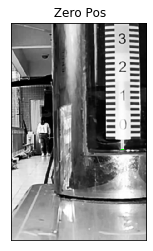

In [19]:
# path = "sample8.jpg" sample3790.jpg sample1070.jpg sample0800.jpg sample0110.jpg sample1560.jpg sample0140.jpg sample1800.jpg
# aimFile errorPic pic2
run()

In [ ]:
# colWid_Mode , 177, "clahe"